In [1]:
from keras.layers import Input, Dense, Conv2D, Flatten, Activation, BatchNormalization, MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
get_ipython().run_line_magic('matplotlib', 'inline')
from collections import defaultdict
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
data_train = pd.read_csv('.\\data\\HPR\\train\\train.csv')
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data_train.columns.to_series().groupby(data_train.dtypes).groups

{dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 

In [5]:
df = data_train.isna().sum()
df[df > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [6]:
data_train.shape

(1460, 81)

In [7]:
#pre processing data
def pre_process(st, label, one, data):
    data['MSSubClass'] = data['MSSubClass'] / 190
    data['LotFrontage'].fillna(0, inplace=True)
    data['Alley'].fillna('NA', inplace=True)
    data['OverallQual'] = data['OverallQual'] / 10
    data['OverallCond'] = data['OverallCond'] / 10
    data['YearBuilt'] = data['YearBuilt'] / 1000
    data['YearRemodAdd'] = data['YearRemodAdd'] /1000
    data['MasVnrType'].fillna('NA', inplace=True)
    data['MasVnrArea'].fillna(0, inplace=True)
    data['ExterQual'] = data['ExterQual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['ExterCond'] = data['ExterCond'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['BsmtQual'] = data['BsmtQual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['BsmtQual'].fillna(0, inplace=True)
    data['BsmtCond'] = data['BsmtCond'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['BsmtCond'].fillna(0, inplace=True)
    data['BsmtExposure'] = data['BsmtExposure'].replace(['Gd', 'Av', 'Mn', 'No'], [1, 0.67, 0.34, 0]).astype(pd.np.float)
    data['BsmtExposure'].fillna(0, inplace=True)
    data['BsmtFinType1'] = data['BsmtFinType1'].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'], [1 ,0.80, 0.64, 0.48, 0.32, 0.16])
    data['BsmtFinType1'].fillna(0, inplace=True)
    data['BsmtFinType2'] = data['BsmtFinType2'].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'], [1 ,0.80, 0.64, 0.48, 0.32, 0.16])
    data['BsmtFinType2'].fillna(0, inplace=True)
    data['HeatingQC'] = data['HeatingQC'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['Electrical'].fillna('Mix', inplace=True)
    data['KitchenQual'] = data['KitchenQual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['Functional'] = data['Functional'].replace(['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
                                                    [1, 0.875, 0.75, 0.625, 0.50, 0.325, 0.2, 0]).astype(pd.np.float)
    data['FireplaceQu'] = data['FireplaceQu'].replace(['Ex', 'Gd', 'TA', 'Fa','Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['FireplaceQu'].fillna(0, inplace=True)
    data['GarageType'].fillna('NA', inplace=True)
    data['GarageYrBlt'] = data['GarageYrBlt'] / 1000
    data['GarageFinish'] = data['GarageFinish'].replace(['Fin', 'RFn', 'Unf'], [1, 0.6, 0.3]).astype(pd.np.float)
    data['GarageFinish'].fillna(0, inplace=True)
    data['GarageQual'] = data['GarageQual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['GarageQual'].fillna(0, inplace=True)
    data['GarageCond'] = data['GarageCond'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['GarageCond'].fillna(0, inplace=True)
    data['PavedDrive'] = data['PavedDrive'].replace(['Y', 'P', 'N'], [1, 0.5, 0]).astype(pd.np.float)
    data['PoolQC'] = data['PoolQC'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['PoolQC'].fillna(0, inplace=True)
    data['Fence'] = data['Fence'].replace(['GdPrv', 'MnPrv', 'GdWo', 'MnWw'], [1, 0.75, 0.50, 0.25]).astype(pd.np.float)
    data['Fence'].fillna(0, inplace=True)
    data['MiscFeature'].fillna('NA', inplace=True)
    data_num = data[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                     'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
                     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
                     'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                     'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
                     'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageCars',
                     'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                     '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal']]
    data_cat = data[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                     'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
                     'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'Foundation',
                     'Heating', 'CentralAir', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']]
    
    label_fit = data_cat.apply(lambda x: label_dict[x.name].fit_transform(x.astype(str)))
    data_cat = one.fit_transform(label_fit)
    return st.fit_transform(np.append(data_num.values, data_cat, axis=1))

In [8]:
st = StandardScaler()
label_dict = defaultdict(LabelEncoder)
# Encoding the variable
one = OneHotEncoder(sparse=False)
data = pre_process(st, label_dict, one, data_train)

D:\ProgramData\Anaconda3\envs\sam_new\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [9]:
data.shape

(1460, 212)

In [10]:
sy = StandardScaler()
data_y = sy.fit_transform(data_train['SalePrice'].values.reshape(data_train.shape[0], 1))

D:\ProgramData\Anaconda3\envs\sam_new\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\ProgramData\Anaconda3\envs\sam_new\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
def get_model(): 
    inputs = Input(shape=(212,))
    x = Dense(1024, activation='tanh')(inputs)
    x = Dense(512, activation='tanh')(x)
    predictions = Dense(1)(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_squared_error'])
    return model

In [12]:
regressor = KerasRegressor(build_fn=get_model, epochs=100, verbose=1)
kfold = KFold(n_splits=10)
results = cross_val_score(regressor, data, data_y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1314/1314 [==============================] - 3s 2ms/step - loss: 1.2386 - mean_squared_error: 1.2386
Epoch 2/100
1314/1314 [==============================] - 0s 266us/step - loss: 0.4347 - mean_squared_error: 0.4347
Epoch 3/100
1314/1314 [==============================] - 0s 184us/step - loss: 0.3184 - mean_squared_error: 0.3184
Epoch 4/100
1314/1314 [==============================] - 0s 187us/step - loss: 0.1943 - mean_squared_error: 0.1943
Epoch 5/100
1314/1314 [==============================] - 0s 172us/step - loss: 0.1243 - mean_squared_error: 0.1243
Epoch 6/100
1314/1314 [==============================] - 0s 249us/step - loss: 0.0973 - mean_squared_error: 0.0973
Epoch 7/100
1314/1314 [==============================] - 0s 239us/step - loss: 0.0762 - mean_squared_error: 0.0762
Epoch 8/100
1314/1314 [==============================] - 0s 240us/step - loss

1314/1314 [==============================] - 0s 345us/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 66/100
1314/1314 [==============================] - 0s 370us/step - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 67/100
1314/1314 [==============================] - 0s 347us/step - loss: 0.0185 - mean_squared_error: 0.0185
Epoch 68/100
1314/1314 [==============================] - 0s 268us/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 69/100
1314/1314 [==============================] - 0s 314us/step - loss: 0.0297 - mean_squared_error: 0.0297
Epoch 70/100
1314/1314 [==============================] - 0s 320us/step - loss: 0.0284 - mean_squared_error: 0.02840s - loss: 0.0326 - mean_squared
Epoch 71/100
1314/1314 [==============================] - 0s 373us/step - loss: 0.0538 - mean_squared_error: 0.0538
Epoch 72/100
1314/1314 [==============================] - 1s 386us/step - loss: 0.0359 - mean_squared_error: 0.0359
Epoch 73/100
1314/1314 [=============================

1314/1314 [==============================] - 1s 452us/step - loss: 0.0279 - mean_squared_error: 0.0279
Epoch 35/100
1314/1314 [==============================] - 1s 433us/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 36/100
1314/1314 [==============================] - 1s 429us/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 37/100
1314/1314 [==============================] - 1s 464us/step - loss: 0.0099 - mean_squared_error: 0.00990s - loss: 0.0102 - mean_squared_err
Epoch 38/100
1314/1314 [==============================] - 0s 188us/step - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 39/100
1314/1314 [==============================] - 0s 200us/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 40/100
1314/1314 [==============================] - 0s 218us/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 41/100
1314/1314 [==============================] - 0s 198us/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 42/100
1314/1314 [=========================

Epoch 4/100
1314/1314 [==============================] - 0s 238us/step - loss: 0.1760 - mean_squared_error: 0.1760
Epoch 5/100
1314/1314 [==============================] - 0s 347us/step - loss: 0.1426 - mean_squared_error: 0.1426
Epoch 6/100
1314/1314 [==============================] - 0s 343us/step - loss: 0.1126 - mean_squared_error: 0.1126
Epoch 7/100
1314/1314 [==============================] - 0s 342us/step - loss: 0.0842 - mean_squared_error: 0.0842
Epoch 8/100
1314/1314 [==============================] - 0s 352us/step - loss: 0.0592 - mean_squared_error: 0.0592
Epoch 9/100
1314/1314 [==============================] - 0s 344us/step - loss: 0.0560 - mean_squared_error: 0.0560
Epoch 10/100
1314/1314 [==============================] - 0s 345us/step - loss: 0.1786 - mean_squared_error: 0.1786
Epoch 11/100
1314/1314 [==============================] - 0s 364us/step - loss: 0.0784 - mean_squared_error: 0.0784
Epoch 12/100
1314/1314 [==============================] - 1s 408us/step - loss

1314/1314 [==============================] - 0s 277us/step - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 75/100
1314/1314 [==============================] - 0s 191us/step - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 76/100
1314/1314 [==============================] - 0s 277us/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 77/100
1314/1314 [==============================] - 0s 341us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 78/100
1314/1314 [==============================] - 0s 345us/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 79/100
1314/1314 [==============================] - 0s 341us/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 80/100
1314/1314 [==============================] - 0s 325us/step - loss: 0.0275 - mean_squared_error: 0.0275
Epoch 81/100
1314/1314 [==============================] - 0s 345us/step - loss: 0.0525 - mean_squared_error: 0.0525
Epoch 82/100
1314/1314 [==============================] - 0s 346us/step - loss: 0.036

1314/1314 [==============================] - 0s 149us/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 45/100
1314/1314 [==============================] - 0s 147us/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 46/100
1314/1314 [==============================] - 0s 147us/step - loss: 0.0253 - mean_squared_error: 0.0253
Epoch 47/100
1314/1314 [==============================] - 0s 146us/step - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 48/100
1314/1314 [==============================] - 0s 146us/step - loss: 0.0185 - mean_squared_error: 0.0185
Epoch 49/100
1314/1314 [==============================] - 0s 146us/step - loss: 0.0219 - mean_squared_error: 0.0219
Epoch 50/100
1314/1314 [==============================] - 0s 148us/step - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 51/100
1314/1314 [==============================] - 0s 150us/step - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 52/100
1314/1314 [==============================] - 0s 146us/step - loss: 0.016

1314/1314 [==============================] - 0s 283us/step - loss: 0.0347 - mean_squared_error: 0.0347
Epoch 14/100
1314/1314 [==============================] - 0s 258us/step - loss: 0.0455 - mean_squared_error: 0.0455
Epoch 15/100
1314/1314 [==============================] - 0s 289us/step - loss: 0.0417 - mean_squared_error: 0.0417
Epoch 16/100
1314/1314 [==============================] - 0s 305us/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 17/100
1314/1314 [==============================] - 0s 345us/step - loss: 0.0278 - mean_squared_error: 0.0278
Epoch 18/100
1314/1314 [==============================] - 0s 169us/step - loss: 0.0307 - mean_squared_error: 0.0307
Epoch 19/100
1314/1314 [==============================] - 0s 135us/step - loss: 0.0274 - mean_squared_error: 0.0274
Epoch 20/100
1314/1314 [==============================] - 0s 136us/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 21/100
1314/1314 [==============================] - 0s 149us/step - loss: 0.027

1314/1314 [==============================] - 0s 350us/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 84/100
1314/1314 [==============================] - 0s 346us/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 85/100
1314/1314 [==============================] - 0s 339us/step - loss: 0.0397 - mean_squared_error: 0.0397
Epoch 86/100
1314/1314 [==============================] - 0s 342us/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 87/100
1314/1314 [==============================] - 0s 345us/step - loss: 0.0535 - mean_squared_error: 0.0535
Epoch 88/100
1314/1314 [==============================] - 0s 339us/step - loss: 0.0460 - mean_squared_error: 0.0460
Epoch 89/100
1314/1314 [==============================] - ETA: 0s - loss: 0.0305 - mean_squared_error: 0.03 - 0s 358us/step - loss: 0.0305 - mean_squared_error: 0.0305
Epoch 90/100
1314/1314 [==============================] - 0s 344us/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 91/100
1314/1314 [=========

1314/1314 [==============================] - 0s 348us/step - loss: 0.0259 - mean_squared_error: 0.0259
Epoch 53/100
1314/1314 [==============================] - 0s 345us/step - loss: 0.0267 - mean_squared_error: 0.0267
Epoch 54/100
1314/1314 [==============================] - 0s 348us/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 55/100
1314/1314 [==============================] - 0s 346us/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 56/100
1314/1314 [==============================] - 0s 293us/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 57/100
1314/1314 [==============================] - 0s 268us/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 58/100
1314/1314 [==============================] - 0s 348us/step - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 59/100
1314/1314 [==============================] - 0s 347us/step - loss: 0.0437 - mean_squared_error: 0.0437
Epoch 60/100
1314/1314 [==============================] - 0s 216us/step - loss: 0.023

1314/1314 [==============================] - 0s 318us/step - loss: 0.0257 - mean_squared_error: 0.0257
Epoch 23/100
1314/1314 [==============================] - 0s 241us/step - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 24/100
1314/1314 [==============================] - 0s 282us/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 25/100
1314/1314 [==============================] - 0s 350us/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 26/100
1314/1314 [==============================] - 0s 323us/step - loss: 0.0285 - mean_squared_error: 0.0285
Epoch 27/100
1314/1314 [==============================] - 0s 335us/step - loss: 0.0217 - mean_squared_error: 0.0217
Epoch 28/100
1314/1314 [==============================] - 0s 348us/step - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 29/100
1314/1314 [==============================] - 1s 420us/step - loss: 0.0280 - mean_squared_error: 0.0280
Epoch 30/100
1314/1314 [==============================] - 1s 408us/step - loss: 0.025

1314/1314 [==============================] - 0s 370us/step - loss: 0.0165 - mean_squared_error: 0.0165
Epoch 93/100
1314/1314 [==============================] - 1s 392us/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 94/100
1314/1314 [==============================] - 1s 394us/step - loss: 0.0245 - mean_squared_error: 0.0245
Epoch 95/100
1314/1314 [==============================] - 1s 386us/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 96/100
1314/1314 [==============================] - 0s 373us/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 97/100
1314/1314 [==============================] - 0s 356us/step - loss: 0.0185 - mean_squared_error: 0.01850s - loss: 0.0194 - mean_squared_e
Epoch 98/100
1314/1314 [==============================] - 0s 354us/step - loss: 0.0178 - mean_squared_error: 0.0178
Epoch 99/100
1314/1314 [==============================] - 0s 354us/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 100/100
146/146 [============================

1314/1314 [==============================] - 0s 372us/step - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 62/100
1314/1314 [==============================] - 0s 365us/step - loss: 0.0257 - mean_squared_error: 0.0257
Epoch 63/100
1314/1314 [==============================] - 0s 366us/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 64/100
1314/1314 [==============================] - 0s 365us/step - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 65/100
1314/1314 [==============================] - 0s 354us/step - loss: 0.0248 - mean_squared_error: 0.0248
Epoch 66/100
1314/1314 [==============================] - 0s 346us/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 67/100
1314/1314 [==============================] - 0s 351us/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 68/100
1314/1314 [==============================] - 0s 292us/step - loss: 0.0149 - mean_squared_error: 0.0149
Epoch 69/100
1314/1314 [==============================] - 0s 338us/step - loss: 0.011

1314/1314 [==============================] - 0s 151us/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 32/100
1314/1314 [==============================] - 0s 149us/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 33/100
1314/1314 [==============================] - 0s 148us/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 34/100
1314/1314 [==============================] - 0s 152us/step - loss: 0.0216 - mean_squared_error: 0.0216
Epoch 35/100
1314/1314 [==============================] - 0s 149us/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 36/100
1314/1314 [==============================] - 0s 173us/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 37/100
1314/1314 [==============================] - 0s 168us/step - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 38/100
1314/1314 [==============================] - 0s 166us/step - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 39/100
1314/1314 [==============================] - 0s 168us/step - loss: 0.017

1314/1314 [==============================] - 1s 614us/step - loss: 1.1758 - mean_squared_error: 1.1758
Epoch 2/100
1314/1314 [==============================] - 0s 298us/step - loss: 0.4589 - mean_squared_error: 0.4589
Epoch 3/100
1314/1314 [==============================] - 0s 367us/step - loss: 0.2527 - mean_squared_error: 0.2527
Epoch 4/100
1314/1314 [==============================] - 0s 354us/step - loss: 0.2135 - mean_squared_error: 0.2135
Epoch 5/100
1314/1314 [==============================] - 0s 355us/step - loss: 0.1281 - mean_squared_error: 0.1281
Epoch 6/100
1314/1314 [==============================] - 0s 353us/step - loss: 0.0873 - mean_squared_error: 0.0873
Epoch 7/100
1314/1314 [==============================] - 0s 357us/step - loss: 0.0789 - mean_squared_error: 0.0789
Epoch 8/100
1314/1314 [==============================] - 0s 349us/step - loss: 0.1050 - mean_squared_error: 0.1050
Epoch 9/100
1314/1314 [==============================] - 0s 357us/step - loss: 0.0537 - mean

1314/1314 [==============================] - 0s 373us/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 72/100
1314/1314 [==============================] - 1s 392us/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 73/100
1314/1314 [==============================] - 0s 371us/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 74/100
1314/1314 [==============================] - 0s 352us/step - loss: 0.0238 - mean_squared_error: 0.0238
Epoch 75/100
1314/1314 [==============================] - 0s 359us/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 76/100
1314/1314 [==============================] - 0s 363us/step - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 77/100
1314/1314 [==============================] - 0s 353us/step - loss: 0.0287 - mean_squared_error: 0.0287
Epoch 78/100
1314/1314 [==============================] - 0s 357us/step - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 79/100
1314/1314 [==============================] - 0s 352us/step - loss: 0.023

In [13]:
regressor = KerasRegressor(build_fn=get_model, epochs=100, verbose=1)
h = regressor.fit(data, data_y, epochs=100,  verbose=1, validation_split=0.2)

Train on 1168 samples, validate on 292 samples
Epoch 1/100
1168/1168 [==============================] - 1s 885us/step - loss: 1.3620 - mean_squared_error: 1.3620 - val_loss: 0.7326 - val_mean_squared_error: 0.7326
Epoch 2/100
1168/1168 [==============================] - 0s 250us/step - loss: 0.4860 - mean_squared_error: 0.4860 - val_loss: 0.4198 - val_mean_squared_error: 0.4198
Epoch 3/100
1168/1168 [==============================] - 0s 348us/step - loss: 0.2821 - mean_squared_error: 0.2821 - val_loss: 0.3691 - val_mean_squared_error: 0.3691
Epoch 4/100
1168/1168 [==============================] - 0s 374us/step - loss: 0.1725 - mean_squared_error: 0.1725 - val_loss: 0.2806 - val_mean_squared_error: 0.2806
Epoch 5/100
1168/1168 [==============================] - 0s 343us/step - loss: 0.1186 - mean_squared_error: 0.1186 - val_loss: 0.3006 - val_mean_squared_error: 0.3006
Epoch 6/100
1168/1168 [==============================] - 0s 341us/step - loss: 0.0899 - mean_squared_error: 0.0899 - v

1168/1168 [==============================] - 0s 163us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.2237 - val_mean_squared_error: 0.2237
Epoch 50/100
1168/1168 [==============================] - 0s 159us/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.2501 - val_mean_squared_error: 0.2501
Epoch 51/100
1168/1168 [==============================] - 0s 159us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.2438 - val_mean_squared_error: 0.2438
Epoch 52/100
1168/1168 [==============================] - 0s 159us/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.2349 - val_mean_squared_error: 0.2349
Epoch 53/100
1168/1168 [==============================] - 0s 162us/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.2439 - val_mean_squared_error: 0.2439
Epoch 54/100
1168/1168 [==============================] - 0s 161us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.2444 - val_mean_squared_error: 0.2444
Epoch

Epoch 98/100
1168/1168 [==============================] - 0s 159us/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.2445 - val_mean_squared_error: 0.2445
Epoch 99/100
1168/1168 [==============================] - 0s 163us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.2479 - val_mean_squared_error: 0.2479
Epoch 100/100
1168/1168 [==============================] - 0s 162us/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.2418 - val_mean_squared_error: 0.2418


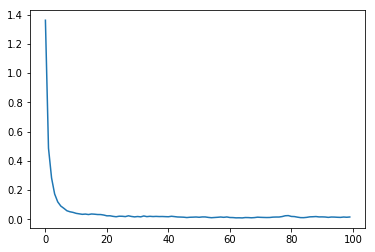

In [14]:
plt.plot(h.history['mean_squared_error'])

1460/1460 [==============================] - 0s 125us/step


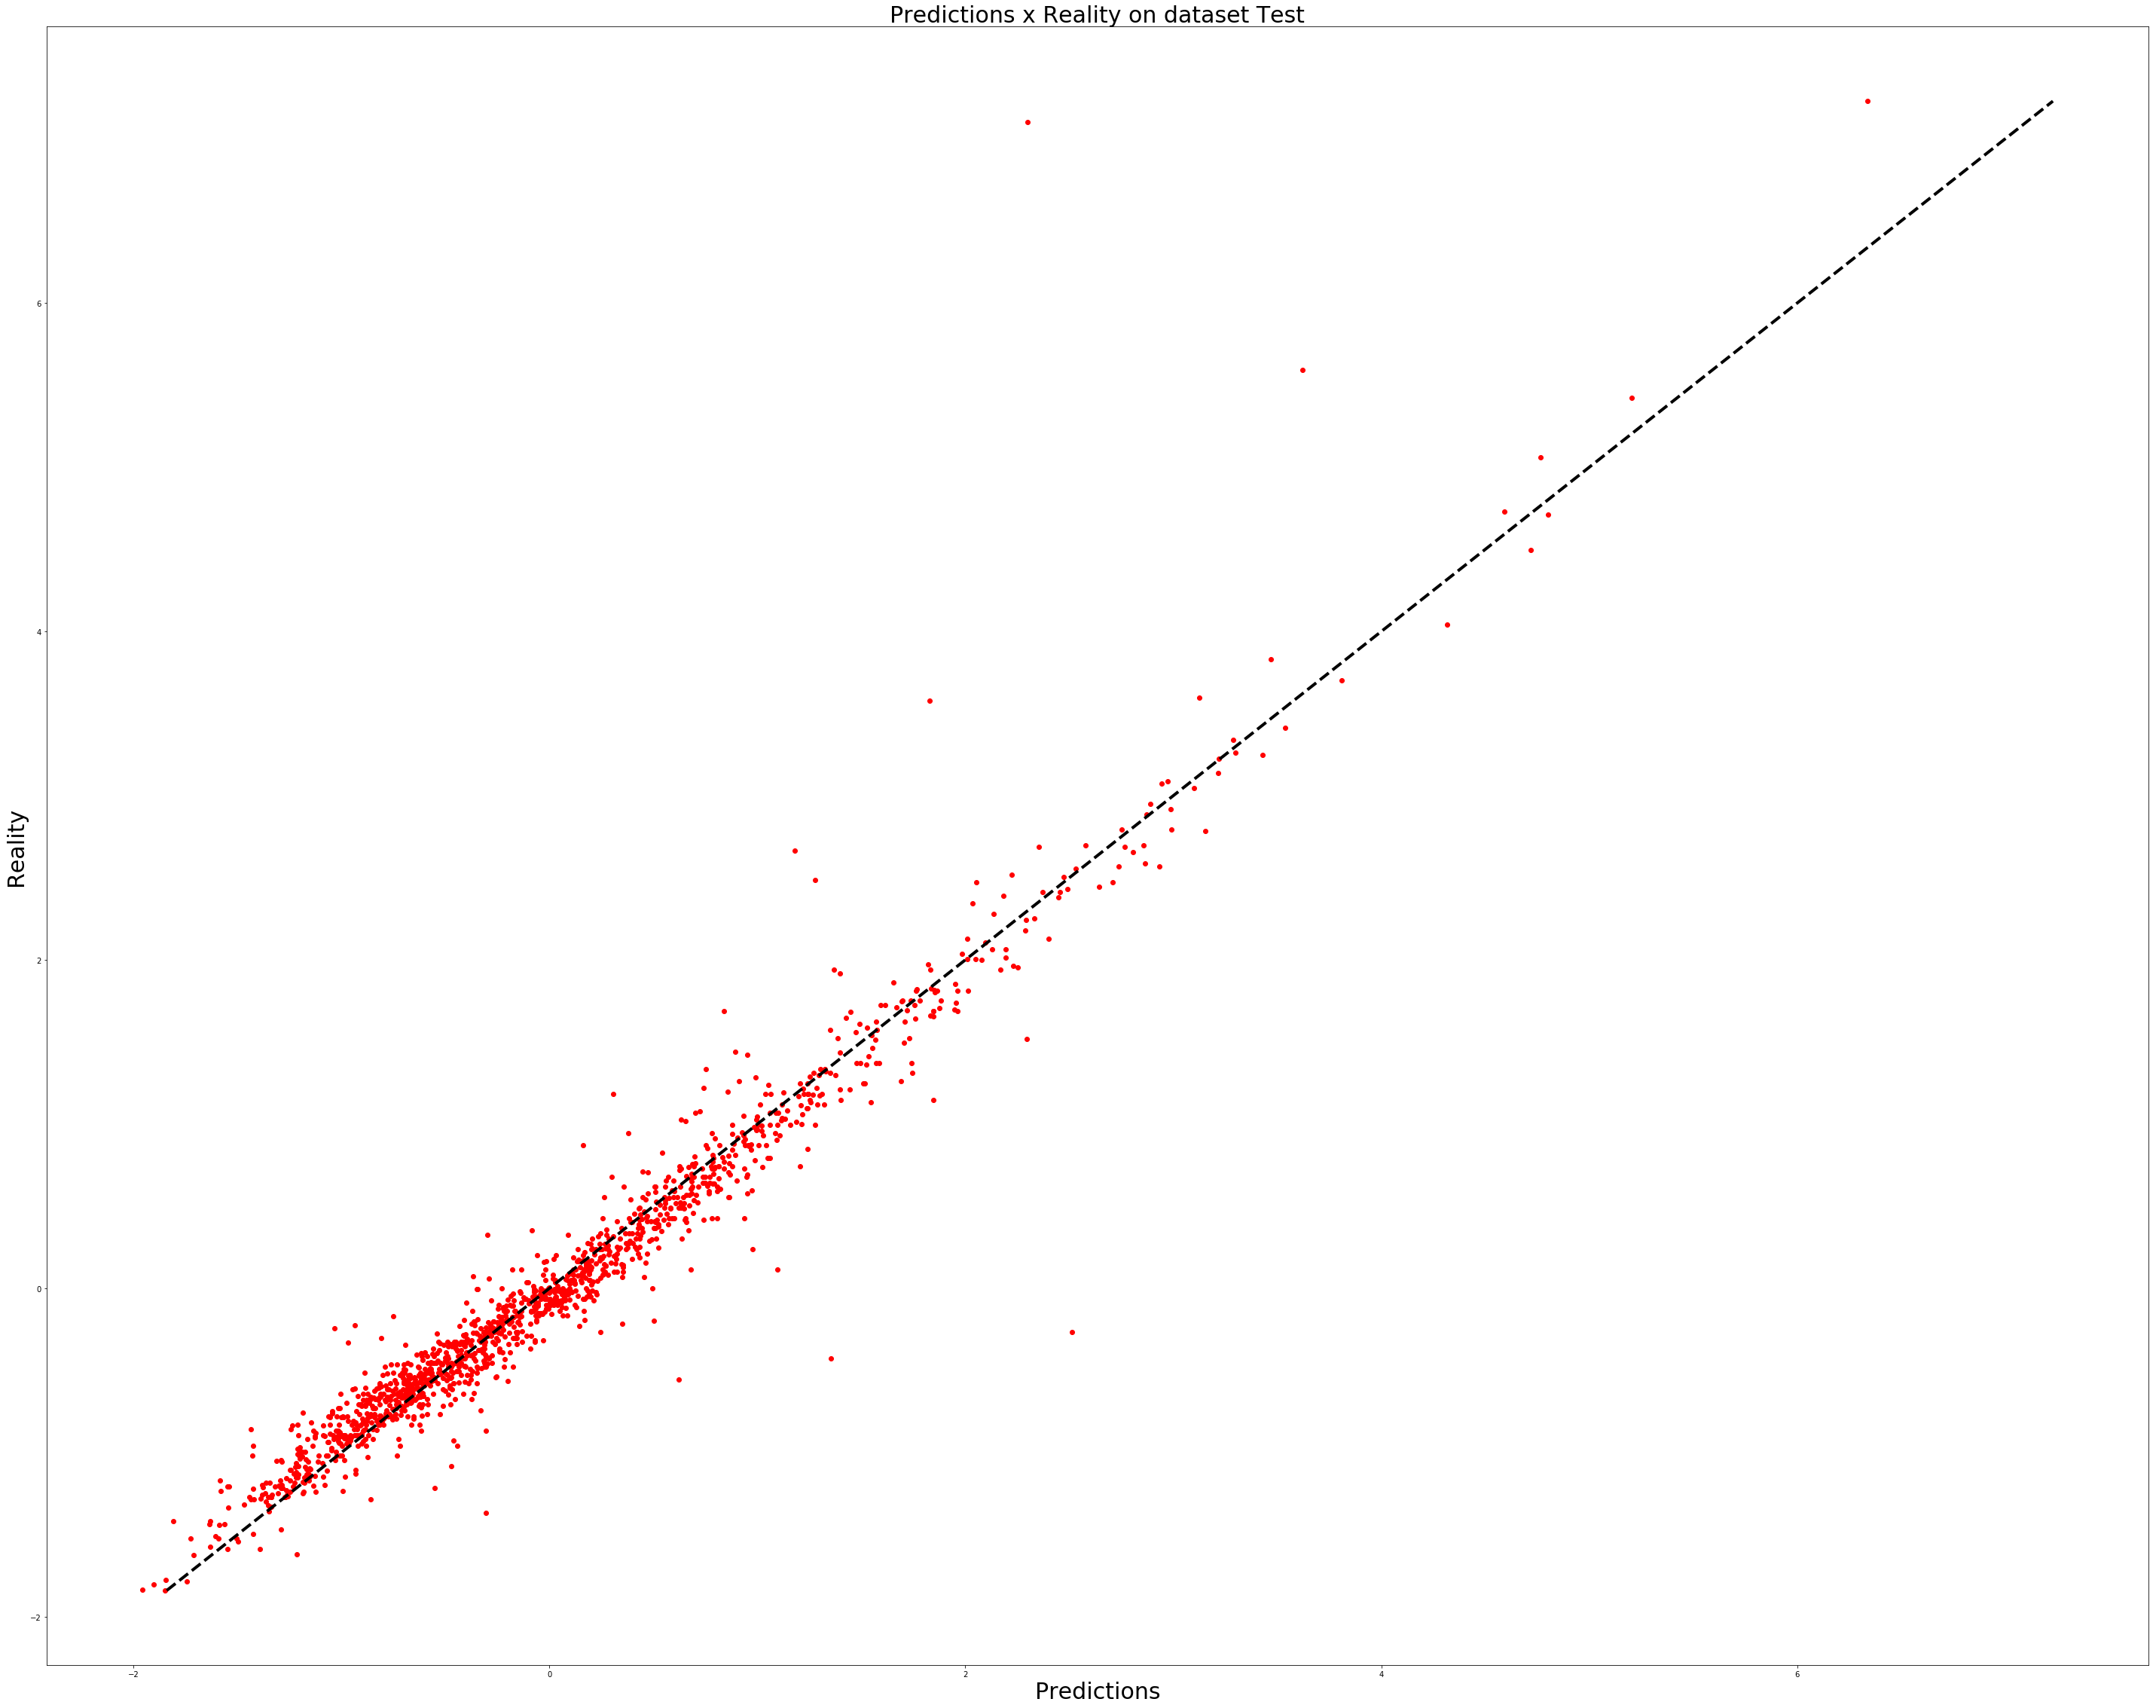

In [15]:
fig, ax = plt.subplots(figsize=(50, 40))
predictions = regressor.predict(data)
reality = data_y
plt.style.use('ggplot')
plt.plot(predictions, reality, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(mean_absolute_error(data_y,predictions))
print(mean_squared_error(data_y,predictions))
print(r2_score(data_y,predictions))

0.13549667387248993
0.061987082987087
0.938012917012913


In [17]:
data_test = pd.read_csv('.\\data\\6\\test\\test.csv')
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [18]:
df = data_test.isna().sum()
df[df > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [19]:
def pre_process_test(st, label, one, data):
    data['MSSubClass'] = data['MSSubClass'] / 190
    data['LotFrontage'].fillna(0, inplace=True)
    data['Alley'].fillna('NA', inplace=True)
    data['OverallQual'] = data['OverallQual'] / 10
    data['OverallCond'] = data['OverallCond'] / 10
    data['YearBuilt'] = data['YearBuilt'] / 1000
    data['YearRemodAdd'] = data['YearRemodAdd'] /1000
    data['MasVnrType'].fillna('NA', inplace=True)
    data['MasVnrArea'].fillna(0, inplace=True)
    data['ExterQual'] = data['ExterQual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['ExterCond'] = data['ExterCond'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['BsmtQual'] = data['BsmtQual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['BsmtQual'].fillna(0, inplace=True)
    data['BsmtCond'] = data['BsmtCond'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['BsmtCond'].fillna(0, inplace=True)
    data['BsmtExposure'] = data['BsmtExposure'].replace(['Gd', 'Av', 'Mn', 'No'], [1, 0.67, 0.34, 0]).astype(pd.np.float)
    data['BsmtExposure'].fillna(0, inplace=True)
    data['BsmtFinType1'] = data['BsmtFinType1'].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'], [1 ,0.80, 0.64, 0.48, 0.32, 0.16])
    data['BsmtFinType1'].fillna(0, inplace=True)
    data['BsmtFinType2'] = data['BsmtFinType2'].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'], [1 ,0.80, 0.64, 0.48, 0.32, 0.16])
    data['BsmtFinType2'].fillna(0, inplace=True)
    data['HeatingQC'] = data['HeatingQC'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['Electrical'].fillna('Mix', inplace=True)
    data['KitchenQual'] = data['KitchenQual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['Functional'] = data['Functional'].replace(['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
                                                    [1, 0.875, 0.75, 0.625, 0.50, 0.325, 0.2, 0]).astype(pd.np.float)
    data['FireplaceQu'] = data['FireplaceQu'].replace(['Ex', 'Gd', 'TA', 'Fa','Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['FireplaceQu'].fillna(0, inplace=True)
    data['GarageType'].fillna('NA', inplace=True)
    data['GarageYrBlt'] = data['GarageYrBlt'] / 1000
    data['GarageFinish'] = data['GarageFinish'].replace(['Fin', 'RFn', 'Unf'], [1, 0.6, 0.3]).astype(pd.np.float)
    data['GarageFinish'].fillna(0, inplace=True)
    data['GarageQual'] = data['GarageQual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['GarageQual'].fillna(0, inplace=True)
    data['GarageCond'] = data['GarageCond'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['GarageCond'].fillna(0, inplace=True)
    data['PavedDrive'] = data['PavedDrive'].replace(['Y', 'P', 'N'], [1, 0.5, 0]).astype(pd.np.float)
    data['PoolQC'] = data['PoolQC'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [1, 0.8, 0.6, 0.4, 0.2]).astype(pd.np.float)
    data['PoolQC'].fillna(0, inplace=True)
    data['Fence'] = data['Fence'].replace(['GdPrv', 'MnPrv', 'GdWo', 'MnWw'], [1, 0.75, 0.50, 0.25]).astype(pd.np.float)
    data['Fence'].fillna(0, inplace=True)
    data['MiscFeature'].fillna('NA', inplace=True)
    #Extra
    data['MSZoning'].fillna(data['MSZoning'].mode()[0], inplace=True)
    data['Utilities'].fillna(data['Utilities'].mode()[0], inplace=True)
    data['Exterior1st'].fillna(data['Exterior1st'].mode()[0], inplace=True)
    data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0], inplace=True)
    data['BsmtFinSF1'].fillna(0, inplace=True)
    data['BsmtFinSF2'].fillna(0, inplace=True)
    data['BsmtUnfSF'].fillna(0, inplace=True)
    data['TotalBsmtSF'].fillna(0, inplace=True)
    data['BsmtFullBath'].fillna(0, inplace=True)
    data['BsmtHalfBath'].fillna(0, inplace=True)
    data['KitchenQual'].fillna(0.6, inplace=True)
    data['Functional'].fillna(1, inplace=True)
    data['GarageCars'].fillna(0, inplace=True)
    data['GarageArea'].fillna(0, inplace=True)
    data['SaleType'].fillna(data['SaleType'].mode()[0], inplace=True)
    data_num = data[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                     'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
                     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
                     'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                     'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
                     'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageCars',
                     'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                     '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal']]
    data_cat = data[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                     'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
                     'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'Foundation',
                     'Heating', 'CentralAir', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']]
    
    label_fit = data_cat.apply(lambda x: label_dict[x.name].transform(x.astype(str)))
    data_cat = one.transform(label_fit)
    return st.transform(np.append(data_num.values, data_cat, axis=1))

In [20]:
data_x = pre_process_test(st, label_dict, one, data_test)

In [21]:
data_y_test = regressor.predict(data_x)

1459/1459 [==============================] - 0s 36us/step


In [22]:
df = pd.DataFrame(data=sy.inverse_transform(data_y_test))

In [23]:
data_test_i = data_test[['Id']]
data_test_ans = pd.concat([data_test_i, df], axis=1)
data_test_ans.columns = ['Id', 'SalePrice']
data_test_ans.head()

,Id,SalePrice
0,1461,123295.37500
1,1462,170846.96875
2,1463,203811.78125
3,1464,206804.15625
4,1465,199481.50000


In [24]:
data_test_ans.to_csv("sub.csv", index=False)